In [3]:
import numpy as np
from openpyxl import load_workbook
wb = load_workbook(filename = 'RF_noise_measurement_Jan_Feb.xlsx')
sheet = wb.active

A = np.array([[i.value for i in j[1:5]] for j in sheet.rows])
B = np.array([[i.value for i in j[6:9]] for j in sheet.rows])

print(A.shape)
print(B.shape)
print(A)
A = np.delete(A,0,0)
B = np.delete(B,0,0)

A = 10**(A/10)
B = 10**(B/10)

TempsA = np.array([13.1,27.6,40.9,56])
TempsB = np.array([28,56,78])

print(A.shape,B.shape)

AvgA = np.empty([2,4])
AvgB = np.empty([2,3])
i=0
while i < 4: 
    AvgA[0,i] = np.mean(A[:,i])
    AvgA[1,i] = np.std(A[:,i])/(A.shape[0])**.5
    i+=1
    
i=0
while i < 3:    
    AvgB[0,i] = np.mean(B[:,i])
    AvgB[1,i] = np.std(B[:,i])/(B.shape[0])**.5
    i+=1

# AvgA = AvgA*1000
# AvgB = AvgB*1000
# why does brent have a .05 in front there?? It's for the 1/root(N)

(402, 4)
(402, 3)
[[ 13.1         27.6         40.9         56.        ]
 [-33.13543073 -29.5204273  -29.6505719  -33.55208994]
 [-38.05504527 -33.83096684 -37.42839506 -38.62393209]
 ...
 [-32.38201977 -32.4651625  -39.38957006 -35.32989094]
 [-37.5994487  -41.94293535 -37.5375873  -37.94109681]
 [-35.84342322 -42.24971782 -36.09989773 -33.56574404]]
(401, 4) (401, 3)


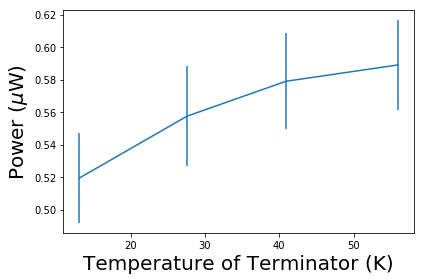

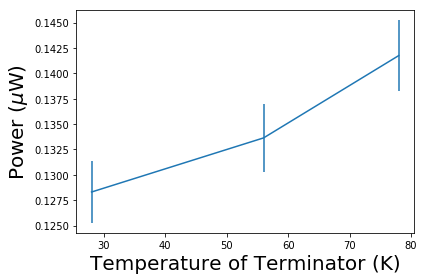

In [178]:
###### %matplotlib inline  
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages


ppA = PdfPages('PlotA.pdf')
ppB = PdfPages('PlotB.pdf')

figA, axA = plt.subplots(1, figsize=(6,4))
plt.errorbar(TempsA, AvgA[0]*1000, yerr=AvgA[1]*1000, label='both limits (default)')  # Test plots
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xlabel('Temperature of Terminator (K)', fontsize = 20)
plt.ylabel('Power ($\mu$W)', fontsize = 20)
# plt.title("Test 2: 2/2/20", fontsize = 20)
# plt.legend(('2/2/20',),loc='upper left')

plt.tight_layout()
ppA.savefig(figA) 
plt.show()

figB, axB = plt.subplots(1, figsize=(6,4))
plt.errorbar(TempsB, AvgB[0]*1000,yerr=AvgB[1]*1000, label='both limits (default)')  # Test plots
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xlabel('Temperature of Terminator (K)', fontsize = 20)
plt.ylabel('Power ($\mu$W)', fontsize = 20)
# plt.title("Test 1: 1/16/20",fontsize = 20)
# plt.legend(('1/16/20',),loc='upper left')

plt.tight_layout()
ppB.savefig(figB) 
plt.show()


ppA.close()
ppB.close()

In [179]:
import matplotlib.pyplot as plt
from scipy import stats

slopeA, interceptA, r_valueA, p_valueA, std_errA = stats.linregress(TempsA, AvgA[0])
slopeB, interceptB, r_valueB, p_valueB, std_errB = stats.linregress(TempsB, AvgB[0])
print("slope: %f    intercept: %f" % (slopeB, interceptB))
print(std_errA)


k_b = 1.38064852 *10**-23 # Boltzman Constant
B = 5*10**6

# T_e = intercept*10**-3 /(k_b*5*10**6)
# print(T_e)   # this doesn't really work because you need to know the gain... 

def N_A(T):
    return slopeA*T+interceptA

def N_B(T):
    return slopeB*T+interceptB
print(interceptA/slopeA)
print(interceptB/slopeB)

print(10*np.log10(slopeA/(k_b*B)))

# Getting T_e with Y-factor measurement:

Y_A = N_A(56)/N_A(13)
Y_B = N_B(78)/N_B(28)
T_e_A = (56- 13*(Y_A))/(Y_A-1)
T_e_B = (78- 28*(Y_B))/(Y_B-1)
print('Effective temperature of our RF system, test 1',T_e_B)
print('Effective temperature of our RF system, test 2',T_e_A)

#Getting the gain: 
def G_A(T):
    return N_A(T)/(k_b*B*(T+T_e_A))
def G_B(T):
    return N_B(T)/(k_b*B*(T+T_e_B))
print('Gain predicted by Y-Factor Method test1 in dB:',10*np.log10(G_B(66)))  # the gain (temp independent) in dB. 
print('Gain predicted by Y-Factor Method test2 in dB:',10*np.log10(G_A(66)))

slope: 0.000000    intercept: 0.000120
3.2255293199003903e-07
312.5496794283303
453.26695034895357
103.69802193523591
Effective temperature of our RF system, test 1 453.26695034895397
Effective temperature of our RF system, test 2 312.54967942833036
Gain predicted by Y-Factor Method test1 in dB: 95.84645716459683
Gain predicted by Y-Factor Method test2 in dB: 103.69802193523591


In [180]:
# Now to get this to work with uncertainties: 
# Notes: 
# Need to tool around with absolute_sigma. After a bit of thought I think it should be at "true". 
from scipy.optimize import curve_fit

k_b = 1.38064852 *10**-23 # Boltzman Constant
B = 5*10**6               # Fieldfox bandwidth

def linfunc(x, m, b):
    return m*x + b 

poptA, pcovA = curve_fit(linfunc,TempsA,AvgA[0], (.000002,.000506), AvgA[1],True)
poptB, pcovB = curve_fit(linfunc,TempsB,AvgB[0], (.000002,.000106), AvgB[1],True)

perrA = np.sqrt(np.diag(pcovA))
perrB = np.sqrt(np.diag(pcovB))

print(pcovA)
print(pcovB)
print('covariance',pcovA[1,0], pcovA[0,1])
# Effective Noise Temperatures from test1 (B) and test2 (A) w/ error propigation
#Note: Should look at off diagonal elements and see how big they are. 

T_A = poptA[1]/poptA[0]
T_B = poptB[1]/poptB[0]
T_A_err = (T_A)*((perrA[0]/poptA[0])**2 + (perrA[1]/poptA[1])**2 +pcovA[1,0]/(poptA[0]*poptA[1]) )**.5   
T_B_err = (T_B)*((perrB[0]/poptB[0])**2 + (perrB[1]/poptB[1])**2 +pcovB[1,0]/(poptB[0]*poptB[1]) )**.5
# Note the tricky sign here. The variables are anticorrelated so the uncertainty in T_e should decrease when you include the cross terms. 

print(T_A,'+-',T_A_err)
print(T_B,'+-',T_B_err)

# Calculated Gain G 

G_A = 10*np.log10(poptA[0]/(k_b*B))
G_B = 10*np.log10(poptB[0]/(k_b*B))

G_A_err = 10*np.log10(perrA[0]/(k_b*B))
G_B_err = 10*np.log10(perrB[0]/(k_b*B)) 

print(G_A,'+-',G_A_err)
print(G_B,'+-',G_B_err)

[[ 7.63434375e-13 -2.63265899e-11]
 [-2.63265899e-11  1.11464298e-09]]
[[ 8.35850092e-15 -4.30105205e-13]
 [-4.30105205e-13  2.56959564e-11]]
covariance -2.632658988400743e-11 -2.632658988400743e-11
310.98894031693294 +- 159.20567426135133
460.99943163211054 +- 153.2494390187301
103.71253801201254 +- 101.02332719308978
95.78119053246907 +- 91.22011061309274


## Analysis of 3rd test
Notes: 
* We were looking at the reflected noise coming back from the two aligned quarter wave plates. 
* We took multiple measurements at each temp to see if there was drift and if the averaging would get rid of noise.
* We took noise measurements at T = 13,26,37.



In [26]:
import numpy as np
from openpyxl import load_workbook
test3_wb = load_workbook(filename = 'RF_noise_measurement3_03122020.xlsx')
sheet = test3_wb.active

T13 = np.array([[i.value for i in j[1:10]] for j in sheet.rows])

print(T13.shape)
print(T13[1,0])
print(type(T13))
T13 = np.delete(T13,0,0)

# T13 = 10**(T13/10)

print(T13)

Avg = np.mean(T13,axis =1)
print(Avg.shape)
Meantot = np.mean(Avg)
stdtot = np.std(Avg)/20
print(Mean,std)

Mean1 = np.mean(T13[:,0])
std1 = np.std(T13[:,0])/20
print(Mean1,std1)
# Need to get to the bottom of why this division isn't working, and then also go back up and make sure it works for A as I thought it did. 

(402, 9)
-28.3657008960861
<class 'numpy.ndarray'>
[[-28.3657008960861 -36.3743681580311 -29.2020742284296 ...
  -32.4114217398646 -31.891829107362 -29.1520382402124]
 [-32.7716765091055 -34.1157125506788 -31.8412045884404 ...
  -33.9789037276826 -29.8150915340551 -34.0738493482792]
 [-27.9331461158808 -34.5095329267323 -35.0245472679378 ...
  -26.1467016400286 -34.2599938936916 -32.7513904467729]
 ...
 [-27.8011375732775 -30.1804690416576 -34.1599339813529 ...
  -35.361716011224 -33.998460166824 -33.4916794243196]
 [-27.6894731177571 -37.4293702516909 -32.7406094051014 ...
  -38.315290828732 -36.4961748041197 -30.1972165233204]
 [-37.405286856919 -34.4783559365051 -27.6545660636184 ...
  -41.4584760598511 -27.884779726908 -31.0671229401484]]
(401,)
-32.193010563664856 0.09973597223359934
-31.96376687806179 0.20141217715590795


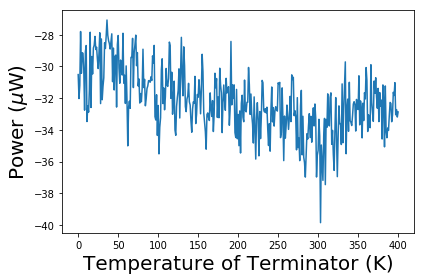

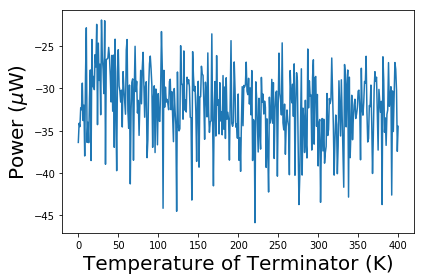

In [22]:
# Plots for above analysis

%matplotlib inline  
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages


# ppA = PdfPages('PlotA.pdf')
# ppB = PdfPages('PlotB.pdf')

figA, axA = plt.subplots(1, figsize=(6,4))
plt.plot(Avg)  # Test plots
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xlabel('Temperature of Terminator (K)', fontsize = 20)
plt.ylabel('Power ($\mu$W)', fontsize = 20)
# plt.title("Test 2: 2/2/20", fontsize = 20)
# plt.legend(('2/2/20',),loc='upper left')

plt.tight_layout()
# ppA.savefig(figA) 
plt.show()


figB, axB = plt.subplots(1, figsize=(6,4))
plt.plot(T13[:,1])  # Test plots
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xlabel('Temperature of Terminator (K)', fontsize = 20)
plt.ylabel('Power ($\mu$W)', fontsize = 20)
# plt.title("Test 2: 2/2/20", fontsize = 20)
# plt.legend(('2/2/20',),loc='upper left')

plt.tight_layout()
# ppA.savefig(figA) 
plt.show()
# figB, axB = plt.subplots(1, figsize=(6,4))
# plt.errorbar(TempsB, AvgB[0]*1000,yerr=AvgB[1]*1000, label='both limits (default)')  # Test plots
# plt.tick_params(axis='both', which='major', labelsize=10)
# plt.xlabel('Temperature of Terminator (K)', fontsize = 20)
# plt.ylabel('Power ($\mu$W)', fontsize = 20)
# # plt.title("Test 1: 1/16/20",fontsize = 20)
# # plt.legend(('1/16/20',),loc='upper left')

# plt.tight_layout()
# ppB.savefig(figB) 
# plt.show()


# ppA.close()
# ppB.close()